## Can Monday predict the Week?

* Explore possible correlations between the opening and reat of the week.

In [344]:
def quadrant_percentages(x, y, x_origin=0, y_origin=0):
    """
    Takes to pairs of co-ordinates and returns percentages of points in each quadrant
    """
    quadrants = [0]*4
    for i, xc in enumerate(x):
        yc = y[i]
        if xc >= x_origin and yc >= y_origin:
            quadrants[0] += 1
        elif xc < x_origin and yc >= y_origin:
            quadrants[1] += 1
        elif xc < x_origin and yc < y_origin:
            quadrants[2] += 1
        elif xc >= x_origin and yc < y_origin:
            quadrants[3] += 1
    return [q*100/len(x) for q in quadrants]

  SPY:  28.85%  27.42%  18.92%  24.81%


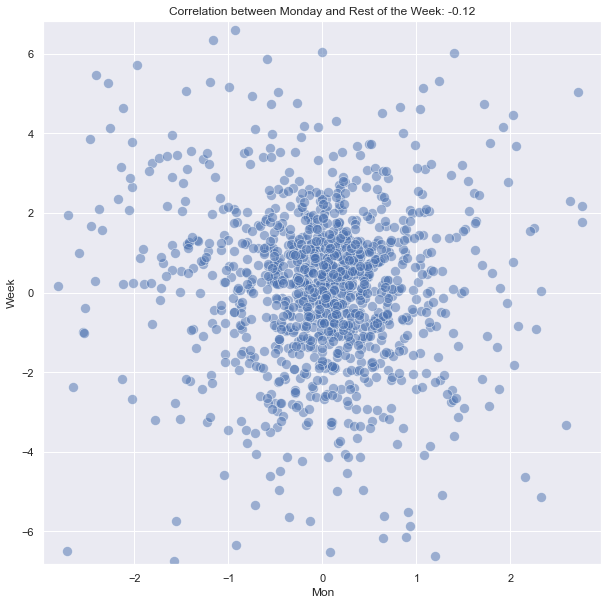

In [345]:
import datetime

ticker = 'SPY'
mkt = ml.timeseries.Ticker(ticker)
weeks = []
week = []
prev_day = -1

# Parse date column into weeks
for day in mkt.timeseries['Date']:
    cur_day = day.weekday()
    if  cur_day > prev_day:
        week.append(day)
    else:
        weeks.append(week)
        week = [day]
    prev_day = cur_day

xy = []
for days in weeks:
    if len(days) < 4:
        continue
    m_open = mkt.timeseries[mkt.timeseries['Date']==days[0]]['Open'].iloc[0]
    m_close = mkt.timeseries[mkt.timeseries['Date']==days[0]]['Close'].iloc[0]
    m_pct = (m_close-m_open)*100/m_open
    w_open = mkt.timeseries[mkt.timeseries['Date']==days[1]]['Open'].iloc[0]
    w_close = mkt.timeseries[mkt.timeseries['Date']==days[-1]]['Close'].iloc[0]
    w_pct = (w_close-m_close)*100/m_close
    xy.append([m_pct, w_pct])

xy = pd.DataFrame(xy, columns=['Mon', 'Week'])
# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(1,1)
ax_1 = fig.add_subplot(grid[0, :])
p = sns.scatterplot(x='Mon', y='Week', data=xy, alpha=.5, s=100)
p.set_xlim((-3*xy['Mon'].std(), 1*3*xy['Mon'].std()))
p.set_ylim((-3*xy['Week'].std(), 1*3*xy['Week'].std()))
p.set_title('Correlation between Monday and Rest of the Week: {:>5.2f}'.format(xy['Mon'].corr(xy['Week'])))

q = quadrant_percentages(xy['Mon'], xy['Week'])
print('{:>5}: {:>6.2f}% {:>6.2f}% {:>6.2f}% {:>6.2f}%'.format(ticker, q[0], q[1], q[2], q[3]))    

### Can morning predict the day?

* Can early morning trading predict the direction of the market
* This is an attempt to built a classifier, a trade simulation approach is below

In [346]:
mkt = ml.timeseries.Ticker('SPY', av_func='TIME_SERIES_INTRADAY_EXTENDED')
mkt.timeseries = mkt.timeseries.sort_values('Date')
# A time slice from the opening of the market and a close-point for the market.
start_time = datetime.time(9,30)
end_time = datetime.time(10,00)
close_time = datetime.time(16,0)

keep_volume = False
threshold = 0.8

vectors = []
dates = []

# Gather transactions from the same day into vectors
cur_date = None
row = None
for i, timestamp in enumerate(mkt.timeseries['Date']):
    date = timestamp.date()
    time = timestamp.time()
    close = mkt.timeseries[mkt.timeseries['Date']==timestamp]['Close'].iloc[0]
    vol = mkt.timeseries[mkt.timeseries['Date']==timestamp]['Volume'].iloc[0]
    if cur_date != date or i+1==len(mkt.timeseries['Date']):
        # if we are starting a new date or on the last rwo of the dataframe
        # save current vector, unless it's the first row of the df
        if cur_date!=None:
            dates.append(cur_date)
        cur_date = date
        if row!=None:
            vectors.append(row)
        row = {}
    if (time >= start_time and time <= end_time) or time == close_time:
        row[time.strftime('%H:%M')] = close # convert timestamps to text
        if keep_volume:
            row[time.strftime('%H:%M')+'_vol'] = vol

# Create dataframe. Drop closing volumes column
vectors = pd.DataFrame(vectors, index=dates)
if keep_volume:
    vectors = vectors.drop(vectors.columns[-1], axis=1)
vectors = vectors.dropna()

# Subtract each column from previous one and convert to pct change
pct_vectors = []
if keep_volume:
    for i in range(2, len(vectors.columns)):
        col_1 = vectors.columns[i]
        col_0 = vectors.columns[i-2]
        pct_vectors.append((vectors[col_1] - vectors[col_0])*100/vectors[col_0])
    vectors = pd.DataFrame(zip(*pct_vectors), columns=vectors.columns[2:], index=vectors.index)
else:
    for i in range(1, len(vectors.columns)):
        col_1 = vectors.columns[i]
        col_0 = vectors.columns[i-1]
        pct_vectors.append((vectors[col_1] - vectors[col_0])*100/vectors[col_0])
    vectors = pd.DataFrame(zip(*pct_vectors), columns=vectors.columns[1:], index=vectors.index)

scaler = StandardScaler()
vectors = pd.DataFrame(scaler.fit_transform(vectors), index=vectors.index, columns=vectors.columns)
vectors

,09:35,09:40,09:45,09:50,09:55,10:00,16:00
2020-09-21,-0.731831,-2.263173,0.650859,1.362639,0.023920,-0.209988,0.627090
2020-09-22,-0.098523,0.443672,-0.634646,-1.867113,-1.068196,0.799649,1.007767
2020-09-23,-0.507172,0.786812,-0.147572,0.143133,-2.325186,-0.625940,-2.483867
2020-09-24,-1.616422,-0.465980,0.898775,3.820806,0.370702,-1.001859,0.480033
2020-09-25,0.596400,-0.631946,1.335837,-1.252778,0.464300,1.640480,1.838143
...,...,...,...,...,...,...,...
2022-09-02,-2.964558,1.000348,-1.662851,0.875356,0.027855,-1.168193,-1.648320
2022-09-06,0.075857,-1.320232,-0.281412,-1.381552,-1.656154,2.016950,-0.241662
2022-09-07,1.163584,1.860195,0.397564,0.119166,-1.149731,-0.483107,1.773783
2022-09-08,-1.298333,0.809252,2.980138,-0.174178,0.814521,0.454592,0.895281


In [347]:
#vectors = vectors[(vectors['16:00']>=threshold) | (vectors['16:00']<=-1*threshold)]
vectors['Target'] = 'N'
vectors['Target'][vectors['16:00']>=threshold] = "U"
vectors['Target'][vectors['16:00']<=-threshold] = "D"
vectors = vectors.drop('16:00', axis=1)
vectors

<ipython-input-347-c1724074c0d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vectors['Target'][vectors['16:00']>=threshold] = "U"
<ipython-input-347-c1724074c0d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vectors['Target'][vectors['16:00']<=-threshold] = "D"


,09:35,09:40,09:45,09:50,09:55,10:00,Target
2020-09-21,-0.731831,-2.263173,0.650859,1.362639,0.023920,-0.209988,N
2020-09-22,-0.098523,0.443672,-0.634646,-1.867113,-1.068196,0.799649,U
2020-09-23,-0.507172,0.786812,-0.147572,0.143133,-2.325186,-0.625940,D
2020-09-24,-1.616422,-0.465980,0.898775,3.820806,0.370702,-1.001859,N
2020-09-25,0.596400,-0.631946,1.335837,-1.252778,0.464300,1.640480,U
...,...,...,...,...,...,...,...
2022-09-02,-2.964558,1.000348,-1.662851,0.875356,0.027855,-1.168193,D
2022-09-06,0.075857,-1.320232,-0.281412,-1.381552,-1.656154,2.016950,N
2022-09-07,1.163584,1.860195,0.397564,0.119166,-1.149731,-0.483107,U
2022-09-08,-1.298333,0.809252,2.980138,-0.174178,0.814521,0.454592,U


In [352]:
from sklearn.ensemble import RandomForestClassifier

X, Y = vectors[vectors.columns[:-1]], vectors[vectors.columns[-1]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
Y_train

model = RandomForestClassifier()
model.fit(X_train, Y_train)

y = model.predict(X_test)
correct = np.sum([1 if p==vectors.iloc[i]['Target'] else 0 for i, p in enumerate(y)])
samples = len(y)
print('{} correct out of {}. Accuracy {}%'.format(correct, samples, correct*100/samples))

73 correct out of 99. Accuracy 73.73737373737374%
